In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import emcee
import corner
from astropy.modeling import models
import astropy.units as u
from scipy.stats import norm, uniform
from IPython.display import display, Math

%matplotlib inline

In [75]:
def log_likelihood(theta, x, y, yerr):
    T_guess, a_guess, v_0_guess, beta_guess, log_f = theta
    #T_guess, a_guess, log_f = theta
    y, yerr =  y.value, yerr.value
    model = lambda v: a_guess*(1-np.exp(-(v.value/(v_0_guess))**beta_guess))*models.BlackBody(temperature = T_guess*u.K, scale = 1*u.MJy/u.sr)(v).value
    
    #model = lambda v: a_guess*(1-np.exp(-(v.value/3000)**1.95))*models.BlackBody(temperature = T_guess*u.K, scale = 1*u.MJy/u.sr)(v).value
    
    sigma2 = yerr ** 2 + model(x) ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model(x)) ** 2 / sigma2 + np.log(sigma2))

In [76]:
def v0_fixed_log_likelihood(theta, x, y, yerr):
    T_guess, a_guess, beta_guess, log_f = theta
    #T_guess, a_guess, log_f = theta
    y, yerr =  y.value, yerr.value
    model = lambda v: a_guess*(1-np.exp(-(v.value/(3000))**beta_guess))*models.BlackBody(temperature = T_guess*u.K, scale = 1*u.MJy/u.sr)(v).value
    
    #model = lambda v: a_guess*(1-np.exp(-(v.value/3000)**1.95))*models.BlackBody(temperature = T_guess*u.K, scale = 1*u.MJy/u.sr)(v).value
    
    sigma2 = yerr ** 2 + model(x) ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model(x)) ** 2 / sigma2 + np.log(sigma2))

In [77]:
def t_only_log_likelihood(theta, x, y, yerr):
    T_guess, a_guess, log_f = theta
    y, yerr =  y.value, yerr.value
    model = lambda v: a_guess*(1-np.exp(-(v.value/3000)**1.95))*models.BlackBody(temperature = T_guess*u.K, scale = 1*u.MJy/u.sr)(v).value
        
    sigma2 = yerr ** 2 + model(x) ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model(x)) ** 2 / sigma2 + np.log(sigma2))

In [78]:
def spectral_log_likelihood(theta, x, y, yerr):
    a_guess, x_0_guess, alpha_guess, log_f = theta
    y, yerr =  y.value, yerr.value
    model = models.PowerLaw1D(amplitude = a_guess*u.MJy/u.sr, x_0 = x_0_guess*u.GHz, alpha = alpha_guess)

    sigma2 = yerr ** 2 + model(x).value ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model(x).value) ** 2 / sigma2 + np.log(sigma2))

In [79]:
def log_prior(theta):
    T_guess, a_guess, v_0_guess, beta_guess, log_f = theta
    """
    if T_guess > 0.1:
        T_prior = norm(loc = 30, scale = 20).pdf(T_guess)
    else:
        T_prior = -np.inf
    a_prior = uniform().pdf(a_guess)
    log_f_prior = uniform(loc = -10, scale = 20).pdf(log_f)

    if np.isnan(T_prior*a_prior*log_f_prior):
        print(T_prior, a_prior, log_f_prior)
    return T_prior*a_prior*log_f_prior
    """
    if 0 < T_guess < 200 and 0 < a_guess < 1 and 0 < v_0_guess < 10000 and -5< beta_guess< 10 and -10.0 < log_f < 1.0:
    #if 0 < T_guess < 200 and 0<a_guess<1 and 0<v_0_guess< 100 and -5< beta_guess< 10 -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

In [80]:
def v0_fixed_log_prior(theta):
    T_guess, a_guess, beta_guess, log_f = theta

    if 0 < T_guess < 200 and 0<a_guess<1 and -5< beta_guess< 10 and -20.0 < log_f < 10.0:
    #if 0 < T_guess < 200 and 0<a_guess<1 and 0<v_0_guess< 100 and -5< beta_guess< 10 -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

In [81]:
def t_only_log_prior(theta):
    T_guess, a_guess, log_f = theta
    if 0 < T_guess < 200 and 0 < a_guess < 1  and -20.0 < log_f < 10.0:
        return 0.0
    return -np.inf
    

In [82]:
def spectral_log_prior(theta):
    a_guess, x_0_guess, alpha_guess, log_f = theta
    """
    if T_guess > 0.1:
        T_prior = norm(loc = 30, scale = 20).pdf(T_guess)
    else:
        T_prior = -np.inf
    a_prior = uniform().pdf(a_guess)
    log_f_prior = uniform(loc = -10, scale = 20).pdf(log_f)

    if np.isnan(T_prior*a_prior*log_f_prior):
        print(T_prior, a_prior, log_f_prior)
    return T_prior*a_prior*log_f_prior
    """
    if 0 < a_guess < 10 and 0.0 < x_0_guess < 10000 and -5 < alpha_guess < 10 and -10.0 < log_f < 1.0:
        
        return 0.0
    return -np.inf

In [83]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    if np.isnan(lp + log_likelihood(theta, x, y, yerr)):
        print(theta,log_likelihood(theta, x, y, yerr))
    return lp + log_likelihood(theta, x, y, yerr)

In [84]:
def v0_fixed_log_probability(theta, x, y, yerr):
    lp = v0_fixed_log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    if np.isnan(lp + v0_fixed_log_likelihood(theta, x, y, yerr)):
        print(theta,v0_fixed_log_likelihood(theta, x, y, yerr))
    return lp + v0_fixed_log_likelihood(theta, x, y, yerr)

In [85]:
def t_only_log_probability(theta, x, y, yerr):
    lp = t_only_log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    if np.isnan(lp + t_only_log_likelihood(theta, x, y, yerr)):
        print(theta,t_only_log_likelihood(theta, x, y, yerr))
    return lp + t_only_log_likelihood(theta, x, y, yerr)

In [86]:
def spectral_log_probability(theta, x, y, yerr):
    lp = spectral_log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    if np.isnan(lp + spectral_log_likelihood(theta, x, y, yerr)):
        print(theta,spectral_log_likelihood(theta, x, y, yerr))
    return lp + spectral_log_likelihood(theta, x, y, yerr)

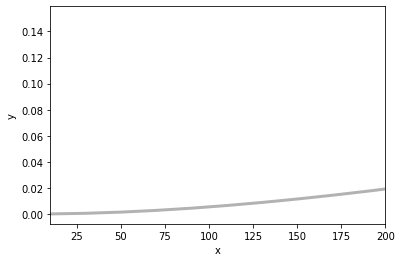

In [54]:
np.random.seed(123)

# Choose the "true" parameters.
#alpha_true = 1
#amp_true = 2
#x_0_true = 50

T_true = 20
a_true = 1e-6

f_true = 0.1

#power_law = models.PowerLaw1D(amplitude = amp_true, x_0 = x_0_true, alpha = alpha_true)

bb = models.BlackBody(temperature = T_true*u.K, scale = a_true * u.MJy/u.sr)
"""
# Generate some synthetic data from the model.
N = 50
#x = np.linspace(10,100, N)
x = np.linspace(10, 1000, N) * u.GHz
yerr = (0.01 + 0.05 * np.random.rand(N))*u.MJy/u.sr
#y = power_law(x)
y = bb(x)
y += np.abs(f_true * y) * 0.1*np.random.randn(N)
y += yerr * np.random.randn(N)
"""


#plt.errorbar(x.value, y.value, yerr=yerr.value, fmt=".k", capsize=0)
x0 = np.linspace(10, 2000, 100)*u.GHz
plt.plot(x0, bb(x0), "k", alpha=0.3, lw=3)
plt.xlim(10, 200)
plt.xlabel("x")
plt.ylabel("y");


In [87]:
x = np.array([1362.69, 250, 350, 500])*u.um
x = x.to(u.GHz, equivalencies=u.spectral())
#y_18 = [4*0.00701, 0.231989, 0.1782091, 0.09595372]*u.MJy/u.sr
y_24 = [0.0044044, 0.21843581, 0.16337599, 0.08575974]*u.MJy/u.sr

y = y_24
yerr = np.array([0.0006369, 0.0349, 0.0144, 0.00776])*u.MJy/u.sr

f_true = 0.1

i = 0
x, y, yerr = x[i:], y[i:], yerr[i:]


Maximum likelihood estimates:
T = 13.335
amp = 1.771e-05
v_0 = 1.883
beta = 1.835
f = 5.934e-03


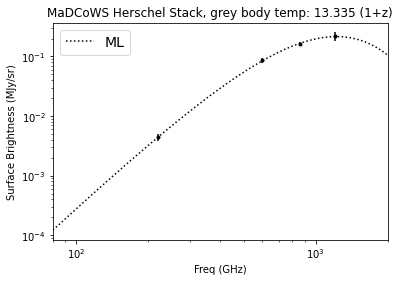

In [54]:
nll = lambda *args: -log_likelihood(*args)
initial = np.array([20, 1e-5, 2, 1.95, np.log(f_true)])

soln = minimize(nll, initial, args=(x, y, yerr))
T_ml, a_ml, v_0_ml, beta_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("T = {0:.3f}".format(T_ml))
print("amp = {0:.3e}".format(a_ml))
print("v_0 = {0:.3f}".format(v_0_ml))
print("beta = {0:.3f}".format(beta_ml))

print("f = {0:.3e}".format(np.exp(log_f_ml)))

model_ml = lambda v: a_ml*(1-np.exp(-(v.value/(v_0_ml))**beta_ml))*models.BlackBody(temperature = T_ml*u.K, scale = 1*u.MJy/u.sr)(v).value

x0 = np.linspace(80, 2000, 100)*u.GHz

plt.errorbar(x.value, y.value, yerr=yerr.value, fmt=".k", capsize=0)
#plt.plot(x0, bb(x0), "k", alpha=0.3, lw=3, label = 'Truth')
plt.plot(x0, model_ml(x0), ":k", label="ML")
plt.title('MaDCoWS Herschel Stack, grey body temp: {0:.3f} (1+z)'.format(T_ml) )
plt.legend(fontsize=14)
plt.xlim(80, 2000)
plt.xscale('log')
plt.yscale('log')


plt.xlabel("Freq (GHz)")
plt.ylabel("Surface Brightness (MJy/sr)");

In [178]:
print(models.BlackBody(temperature = T_ml*u.K, scale = a_ml * u.MJy/u.sr)(220*u.GHz))

0.7791276375080552 MJy / sr


In [56]:
pos = soln.x + 1e-4 * np.random.randn(32, 5)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 10%|▉         | 489/5000 [02:38<25:12,  2.98it/s]/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
 22%|██▏       | 1110/5000 [06:06<21:00,  3.09it/s]/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
100%|██████████| 5000/5000 [26:25<00:00,  3.15it/s]


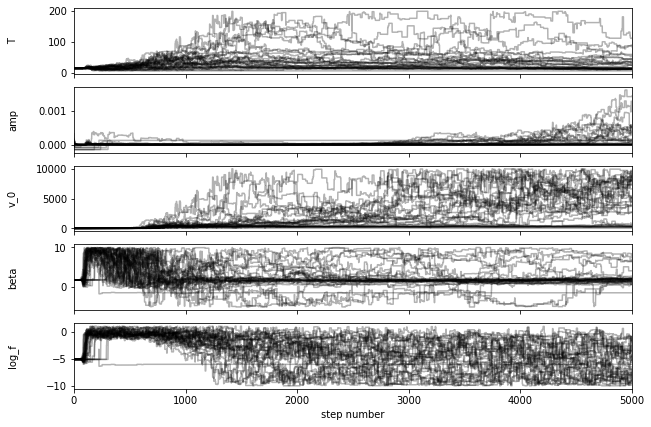

In [57]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['T', 'amp', 'v_0', 'beta', 'log_f']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [191]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [518.35856034 527.1039673  569.85112561 510.83831005 257.5743194 ]

In [192]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
print(flat_samples.shape)

(8512, 5)


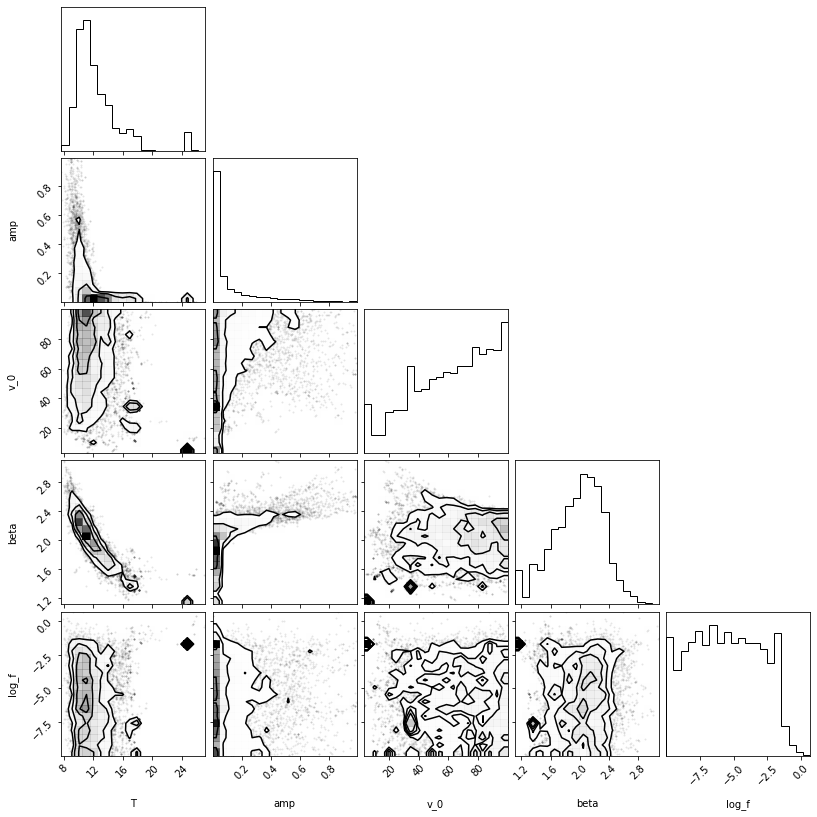

In [193]:
fig = corner.corner(
    flat_samples, labels=labels
);

In [195]:
labels = ['T', 'amp', 'v_0', 'beta', 'log_f']
for i in range(5):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = r"$\mathrm{{{3}}}/(1+z)= {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    
    if labels[i] == 'T':
        title = txt
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

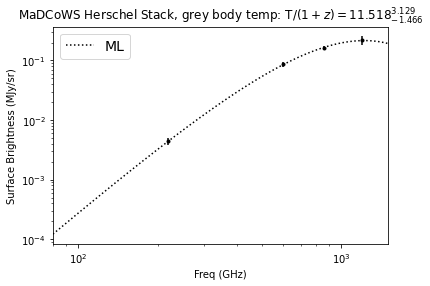

In [200]:
plt.errorbar(x.value, y.value, yerr=yerr.value, fmt=".k", capsize=0)
#plt.plot(x0, bb(x0), "k", alpha=0.3, lw=3, label = 'Truth')

model_ml = lambda v: a_ml*(1-np.exp(-(v.value/(v_0_ml*1000))**beta_ml))*models.BlackBody(temperature = T_ml*u.K, scale = 1*u.MJy/u.sr)(v).value

plt.plot(x0, model_ml(x0), ":k", label="ML")
plt.title('MaDCoWS Herschel Stack, grey body temp: '+ title )
plt.legend(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.xlim(80, 1500)

plt.savefig('./plots/herschel/greybody_mdcw_mcmc.pdf')
plt.savefig('./plots/herschel/greybody_mdcw_mcmc.png', dpi = 300)

plt.xlabel("Freq (GHz)")
plt.ylabel("Surface Brightness (MJy/sr)");

# Spectral Index Fitting

Maximum likelihood estimates:
alpha = -1.455
amp = 1.103e+00
x_0 = 3382.538
f = 1.465e-04


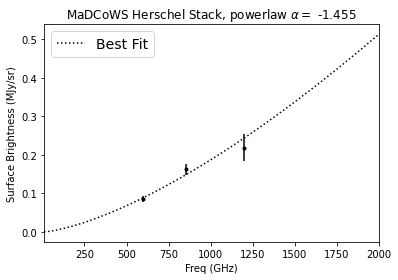

In [80]:
nll = lambda *args: -spectral_log_likelihood(*args)
initial = np.array([1.6974878505056523, 3382.53674018168, -1.7246324134177595, np.log(f_true)])

soln = minimize(nll, initial, args=(x, y, yerr))
amp_ml, x_0_ml, alpha_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("alpha = {0:.3f}".format(alpha_ml))
print("amp = {0:.3e}".format(amp_ml))
print("x_0 = {0:.3f}".format(x_0_ml))
print("f = {0:.3e}".format(np.exp(log_f_ml)))

plt.errorbar(x.value, y.value, yerr=yerr.value, fmt=".k", capsize=0)
#plt.plot(x0, bb(x0), "k", alpha=0.3, lw=3, label = 'Truth')
plt.plot(x0, models.PowerLaw1D(amplitude = amp_ml*u.MJy/u.sr, x_0 = x_0_ml*u.GHz, alpha = alpha_ml)(x0), ":k", label="Best Fit")
plt.title(r'MaDCoWS Herschel Stack, powerlaw $\alpha = $ {0:.3f}'.format(alpha_ml) )
plt.legend(fontsize=14)
plt.xlim(10, 2000)

#plt.savefig('./plots/herschel/blackbody_mdcw.pdf')
#plt.savefig('./plots/herschel/blackbody_mdcw.png', dpi = 300)

plt.xlabel("Freq (GHz)")
plt.ylabel("Surface Brightness (MJy/sr)");

In [81]:
pos = soln.x + 1e-4 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, spectral_log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [04:31<00:00, 18.44it/s]


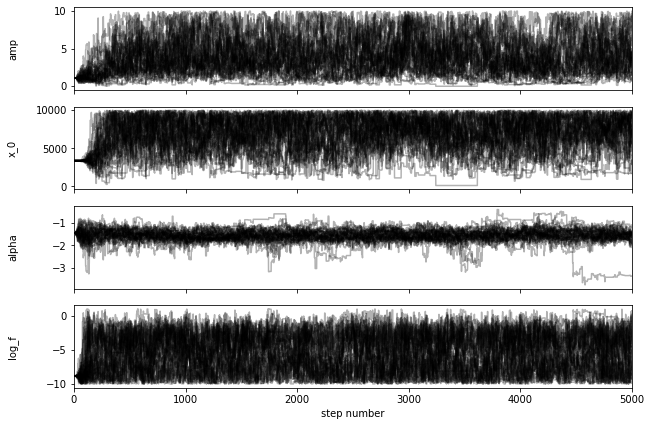

In [83]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['amp', 'x_0', 'alpha', 'log_f']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [84]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [182.18264394 180.41597775 154.96957133 128.12331266]

In [88]:
flat_samples = sampler.get_chain(discard=300, thin=15, flat=True)
print(flat_samples.shape)

(10016, 4)


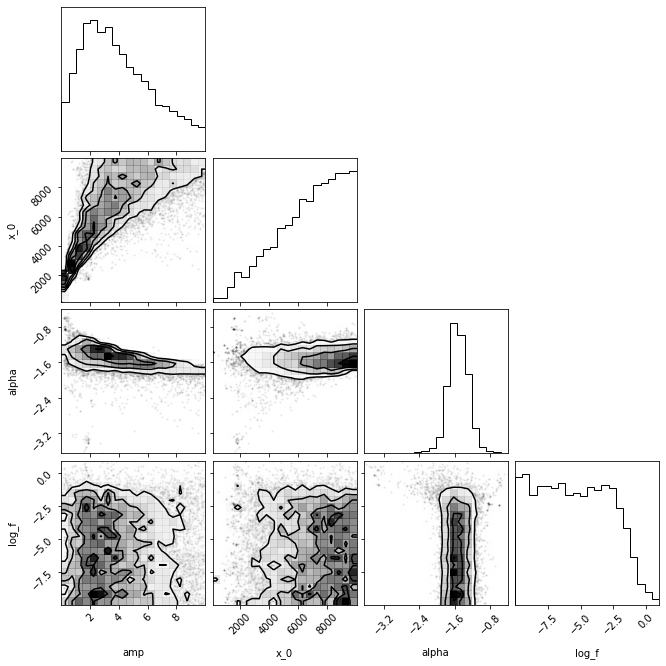

In [89]:
fig = corner.corner(
    flat_samples, labels=labels
);

In [94]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = r"$\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    
    if labels[i] == 'alpha':
        title = txt
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

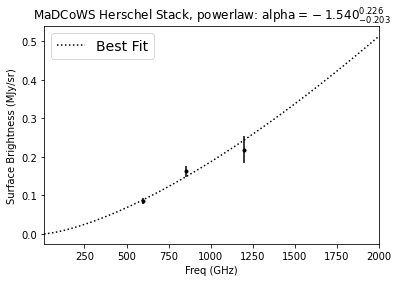

In [95]:

plt.title(r'MaDCoWS Herschel Stack, powerlaw: '+ title )
plt.errorbar(x.value, y.value, yerr=yerr.value, fmt=".k", capsize=0)
#plt.plot(x0, bb(x0), "k", alpha=0.3, lw=3, label = 'Truth')
plt.plot(x0, models.PowerLaw1D(amplitude = amp_ml*u.MJy/u.sr, x_0 = x_0_ml*u.GHz, alpha = alpha_ml)(x0), ":k", label="Best Fit")
plt.legend(fontsize=14)
plt.xlim(10, 2000)

plt.savefig('./plots/herschel/spectral_mdcw_mcmc.pdf')
plt.savefig('./plots/herschel/spectral_mdcw_mcmc.png', dpi = 300)

plt.xlabel("Freq (GHz)")
plt.ylabel("Surface Brightness (MJy/sr)");

# Fixed v_0, beta fit

Maximum likelihood estimates:
T = 12.067
amp = 6.285e-05
f = 1.576e-05


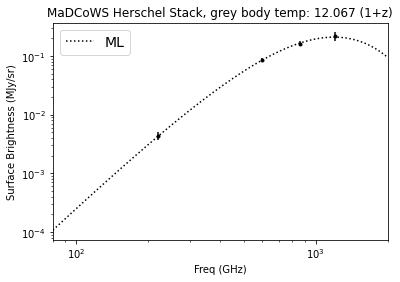

In [15]:
nll = lambda *args: -t_only_log_likelihood(*args)
initial = np.array([20, 1e-5, np.log(f_true)])

soln = minimize(nll, initial, args=(x, y, yerr))
T_ml, a_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("T = {0:.3f}".format(T_ml))
print("amp = {0:.3e}".format(a_ml))


print("f = {0:.3e}".format(np.exp(log_f_ml)))

model_ml = lambda v: a_ml*(1-np.exp(-(v.value/3000)**1.95))*models.BlackBody(temperature = T_ml*u.K, scale = 1*u.MJy/u.sr)(v).value

x0 = np.linspace(80, 2000, 100)*u.GHz

plt.errorbar(x.value, y.value, yerr=yerr.value, fmt=".k", capsize=0)
#plt.plot(x0, bb(x0), "k", alpha=0.3, lw=3, label = 'Truth')
plt.plot(x0, model_ml(x0), ":k", label="ML")
plt.title('MaDCoWS Herschel Stack, grey body temp: {0:.3f} (1+z)'.format(T_ml) )
plt.legend(fontsize=14)
plt.xlim(80, 2000)
plt.xscale('log')
plt.yscale('log')


plt.xlabel("Freq (GHz)")
plt.ylabel("Surface Brightness (MJy/sr)");

In [16]:
pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, t_only_log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 4/5000 [00:01<34:41,  2.40it/s]Traceback (most recent call last):
  File "/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-12-67261b510a50>", line 5, in t_only_log_probability
    if np.isnan(lp + t_only_log_likelihood(theta, x, y, yerr)):
  File "<ipython-input-4-1d3a59a37dbb>", line 6, in t_only_log_likelihood
    sigma2 = yerr ** 2 + model(x) ** 2 * np.exp(2 * log_f)
  File "<ipython-input-4-1d3a59a37dbb>", line 4, in <lambda>
    model = lambda v: a_guess*(1-np.exp(-(v.value/3000)**1.95))*models.BlackBody(temperature = T_guess*u.K, scale = 1*u.MJy/u.sr)(v).value
  File "/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-pa

emcee: Exception while calling your likelihood function:
  params: [ 1.20668817e+01  9.95593529e-05 -1.10574411e+01]
  args: (<Quantity [ 220.00048287, 1199.169832  ,  856.54988   ,  599.584916  ] GHz>, <Quantity [0.0044044 , 0.21843581, 0.16337599, 0.08575974] MJy / sr>, <Quantity [0.0006369, 0.0349   , 0.0144   , 0.00776  ] MJy / sr>)
  kwargs: {}
  exception:


KeyboardInterrupt: 

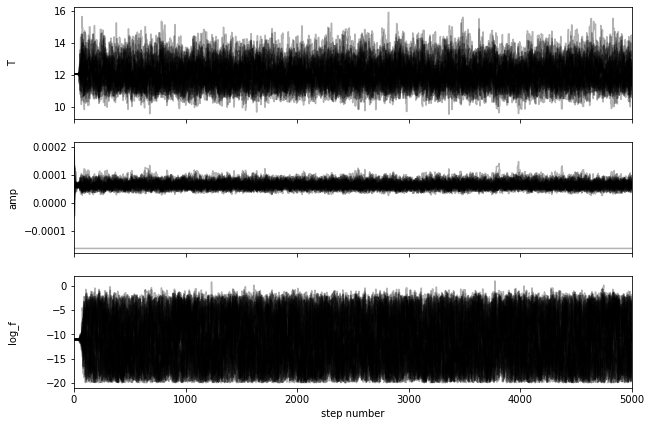

In [35]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['T', 'amp', 'log_f']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [38]:
tau = sampler.get_autocorr_time()
print(tau)
flat_samples = sampler.get_chain(discard=300, thin=15, flat=True)
print(flat_samples.shape)

[        nan 61.6857547  62.53779158]
(10016, 3)


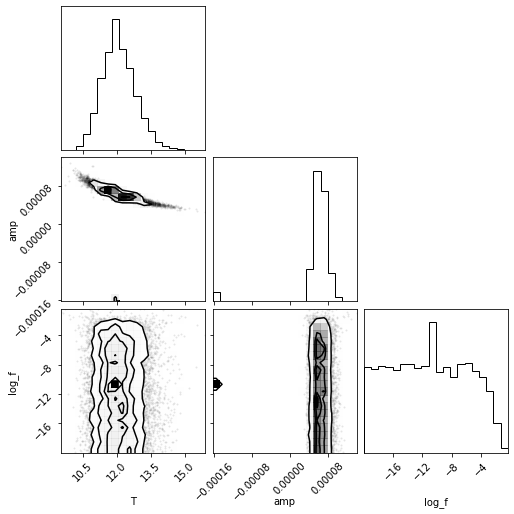

In [39]:
fig = corner.corner(
    flat_samples, labels=labels
);

In [44]:
best_fit = []

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = r"$\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    
    if labels[i] == 'T':
        title = txt
    best_fit.append(mcmc[1])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

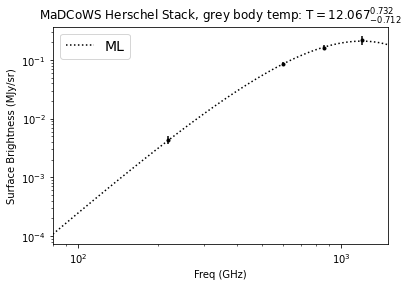

In [45]:
plt.errorbar(x.value, y.value, yerr=yerr.value, fmt=".k", capsize=0)
#plt.plot(x0, bb(x0), "k", alpha=0.3, lw=3, label = 'Truth')

model_ml = lambda v: best_fit[1]*(1-np.exp(-(v.value/3000)**1.95))*models.BlackBody(temperature = best_fit[0]*u.K, scale = 1*u.MJy/u.sr)(v).value

plt.plot(x0, model_ml(x0), ":k", label="ML")
plt.title('MaDCoWS Herschel Stack, grey body temp: '+ title )
plt.legend(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.xlim(80, 1500)

plt.savefig('./plots/herschel/t_only_greybody_mdcw_mcmc.pdf')
plt.savefig('./plots/herschel/t_only_greybody_mdcw_mcmc.png', dpi = 300)

plt.xlabel("Freq (GHz)")
plt.ylabel("Surface Brightness (MJy/sr)");

# Fixed v0 Fit

Maximum likelihood estimates:
T = 12.743
amp = 4.601e-05
beta = 1.850
f = 2.073e-09


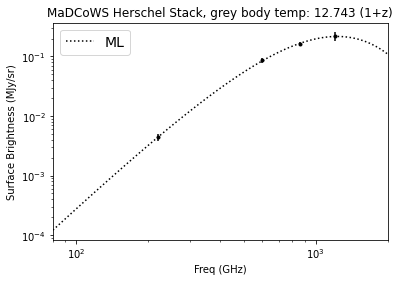

In [58]:
nll = lambda *args: -v0_fixed_log_likelihood(*args)
initial = np.array([20, 1e-5, 1.95, np.log(f_true)])

soln = minimize(nll, initial, args=(x, y, yerr))
T_ml, a_ml, beta_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("T = {0:.3f}".format(T_ml))
print("amp = {0:.3e}".format(a_ml))
print("beta = {0:.3f}".format(beta_ml))


print("f = {0:.3e}".format(np.exp(log_f_ml)))

model_ml = lambda v: a_ml*(1-np.exp(-(v.value/3000)**beta_ml))*models.BlackBody(temperature = T_ml*u.K, scale = 1*u.MJy/u.sr)(v).value

x0 = np.linspace(80, 2000, 100)*u.GHz

plt.errorbar(x.value, y.value, yerr=yerr.value, fmt=".k", capsize=0)
#plt.plot(x0, bb(x0), "k", alpha=0.3, lw=3, label = 'Truth')
plt.plot(x0, model_ml(x0), ":k", label="ML")
plt.title('MaDCoWS Herschel Stack, grey body temp: {0:.3f} (1+z)'.format(T_ml) )
plt.legend(fontsize=14)
plt.xlim(80, 2000)
plt.xscale('log')
plt.yscale('log')


plt.xlabel("Freq (GHz)")
plt.ylabel("Surface Brightness (MJy/sr)");

In [59]:
pos = soln.x + 1e-4 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, v0_fixed_log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 23%|██▎       | 1152/5000 [07:41<26:14,  2.44it/s]/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
100%|██████████| 5000/5000 [34:28<00:00,  2.42it/s]


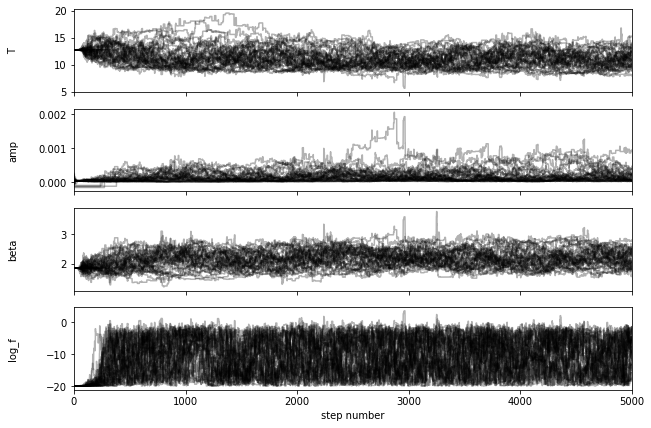

In [64]:
import pickle as pk
#pk.dump(sampler, open('v0_fixed_sampler.p', 'wb'))
#except: pk.load( open('v0_fixed_sampler.p', 'rb'))
sampler = pk.load( open('v0_fixed_sampler.p', 'rb'))
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['T', 'amp', 'beta', 'log_f']
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [108]:
from chainconsumer import ChainConsumer

samples = sampler.get_chain()

c = ChainConsumer()
chain = sampler.chain[:, 500:, :]
uniform = chain.reshape((-1, ndim))

c.add_chain(uniform, parameters = ['T', 'amp', 'beta', 'log_f'], name="Uniform")

def model(v, best_fit):
    return best_fit[1]*(1-np.exp(-(v.value/3000)**best_fit[2]))*models.BlackBody(temperature = best_fit[0]*u.K, scale = 1*u.MJy/u.sr)(v).value

def plot(bounds, title):
    fig, ax = plt.subplots()
    plt.errorbar(x.value, y.value, yerr=yerr.value, fmt="o", lw=1, label="Data")
    ax.plot(x0, bounds[2, :], label="Best Fit", ls="--"),
    plt.fill_between(x0, bounds[0, :], bounds[-1, :], 
                     label="95\% uncertainty", fc="#FFA000", alpha=0.4)
    plt.fill_between(x0, bounds[1, :], bounds[-2, :], 
                     label="68\% uncertainty", fc="#D32F2F", alpha=0.2)
    ax.legend(loc=3)
    ax.set_title(title, fontsize=10);
    ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_xlim(0, 5)

shuffled = np.copy(uniform)
np.random.shuffle(shuffled)
# Row by row construct the prediction of our model using 1000 model realisations
realisations = np.array([model(x0, row[:3]) for row in shuffled[:1000, :]])
bounds = np.percentile(realisations, 100 * norm.cdf([-2, -1, 0, 1, 2]), axis=0)
plot(bounds, 'test')


RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 432x288 with 1 Axes>

In [61]:
#tau = sampler.get_autocorr_time()
flat_samples = sampler.get_chain(discard=300, thin=15, flat=True)
print(flat_samples.shape)

(10016, 4)


[[1.46267499e+01 2.18605169e-05 1.68084697e+00]
 [1.02533519e+01 2.34203151e-04 2.49892963e+00]
 [1.08917157e+01 1.24157736e-04 2.18428310e+00]
 ...
 [9.03975419e+00 3.97183883e-04 2.49764204e+00]
 [9.96079635e+00 2.35098896e-04 2.43085877e+00]
 [9.70835971e+00 2.67690514e-04 2.49778884e+00]]


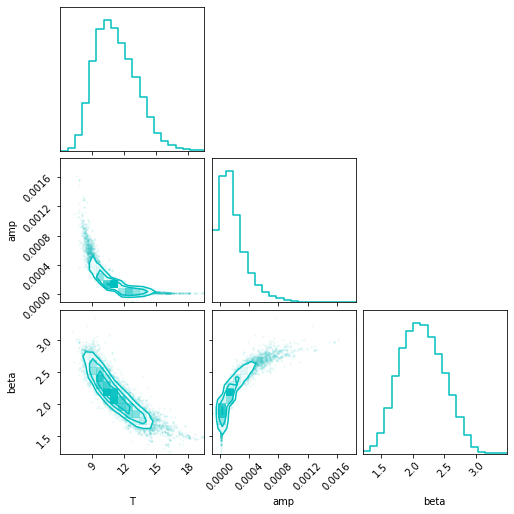

In [62]:
print(flat_samples.T[:3].T)
fig = corner.corner(
    flat_samples.T[:3].T, labels=labels[:4], color = 'c', smooth1d = True
);

In [90]:
best_fit = []

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = r"$\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    
    if labels[i] == 'T':
        title = txt
    best_fit.append(mcmc[1])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [109]:


plt.errorbar(x.value, y.value, yerr=yerr.value, fmt=".k", capsize=0)
#plt.plot(x0, bb(x0), "k", alpha=0.3, lw=3, label = 'Truth')


model_ml = lambda v: best_fit[1]*(1-np.exp(-(v.value/3000)**best_fit[2]))*models.BlackBody(temperature = best_fit[0]*u.K, scale = 1*u.MJy/u.sr)(v).value

plt.plot(x0, model_ml(x0), ":k", label="ML")
plt.title('MaDCoWS Herschel Stack, grey body temp: '+ title )
plt.legend(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.xlim(80, 1500)

plt.savefig('./plots/herschel/v0_fixed_greybody_mdcw_mcmc.pdf')
plt.savefig('./plots/herschel/v0_fixed_greybody_mdcw_mcmc.png', dpi = 300)

plt.xlabel("Freq (GHz)")
plt.ylabel("Surface Brightness (MJy/sr)");

RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 432x288 with 1 Axes>

In [111]:
plt.plot(x0, model_ml(x0))


RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 432x288 with 1 Axes>